#<center> Comparison of the fire rate of spread in WRF-SFIRE and FARSITE<center/>

**<center> University of Colorado Denver</center>**
**<center> Date: 13th December 2021 </center>**
**<center> Instructor: Jan Mandel**
**<center> Students for MATH 4779 003</center>**

<center> Christopher Graham</center>
<center> Racheal Asamoah</center>
<center> Efosa Osazuwa</center>
<center> Austin Talley</center>


## Abstract 

Though it is known that the Weather Research and Forecasting Model - Fire Spread Model (WRF-SFIRE) and Fire Area Simulator (FARSITE) use fundamentally different methods to expand the fire perimeter, it was believed that the two applications also use different approaches to calculating the rate of spread at a given point. This project sought to uncover the differences in the rate of spread (ROS) calculations for both WRF-SFIRE and FARSITE and apply the techniques that FARSITE employs within WRF-SFIRE.

We identified the key major difference between WRF-SFIRE and FARSITE ROS calculations as the wind-slope vectoring of FARSITE and its use in the formation of an elliptical fire spread.

Prepare the notebook dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
import pandas as pd

### Table of contents


[1 introduction](#introduction)

[2 Background](#background)

[2.1 The wind speed vector and the slope vector](#windspeedvector) 

[2.2 Rothermel formula](#Rothermelformula) 

[2.2.1 ROS Code](#ROSCode)

[2.4 Fire propagation by the ellipsoid method in FARSITE](#FirepropagationFARSITE)

[2.4.1 Richard's Differential Equations (Huygen's Principle)](#DifferentialEquations)

[2.4.2 Ellipse Formation](#EllipseFormation)

[2.4.2.1 Wind Slope resultant vector](#WindSlope) 

[2.4.2.2 FARSITE Modified Rothermel ROS Equation](#ModifiedRothermel)


[2.4.2.3 Elliptical Fire Size Proportions](#EllipticalFireSize) 

[2.5 Fire propagation in WRF-SFIRE](#FirepropagationWRF-SFIRE)

[3 Methods](#Methods)

[3.1 Computing the rate of spread in the direction normal](#ComputingROS)

[4 Results](#Results)

[5 Conclusion](#conclusion)

[Contributions of Authors](#Contributions)

[Acknowledgements](#acknowledgements)

[References](#references)



##1 Introduction <a name='introduction'></a>


Fire modeling is an increasingly important field of study as climate change takes hold and intensifies the duration and magnitude of fires worldwide.
Fire propagation is a particularly important aspect of fire modeling because knowing where a fire is going is the first step in preparing countermeasures for firefighting.There are several models that can model how fire progresses over time two important models in the fire modeling lexicon:

1.   Fire Spread Model (WRF-SFIRE) which uses the level-set method
2.   Fire Area Simulator (FARSITE) which uses the ellipsoid method

These two models at the highest level calculate how fire spreads at a given point given basic variables such as: fuel type, wind speed, and slope of the terrain.

The primary objective of this project is to reconcile and compare between these two methods and how they are calculated. In this project, two models will be taken and translated into a single shared language (python). Then these two models will be fed into the same type of fuel, wind and slope vector data. After that, the outputs from each models will be graphically and numerically compared.




## 2 Background <a name='background'></a>

### 2.1 The wind speed vector and the slope vector <a name='windspeedvector'></a>

The wind speed is a vector. We can write the wind vector in Cartesian coordinates as $$\vec{w}=(w_x,w_y)\quad \text{(m/s)}.$$ The $x,y$ axes can be, e.g., east-west and south-north, but that is not important here.

The slope is also a vector. Denote by $z=z(x,y)$ the terrain height, e.g., above the sea level. The slope vector is the gradient of the terrain height. This vector can be conceptualized as the height above sea level gained for a 1 m movement in the x direction and a 1 m movement in the y direction. $$\vec{s}=\left(\frac{\partial z}{\partial x},\frac{\partial z}{\partial y}\right)\quad\text{(m/m})$$.  


The angle at which the slope moves given $\vec s$ is denoted as $\phi$. Thus, $\tan\phi$ = $||\vec s||$. This is why slope is referred to and represented as $\tan \phi$. 

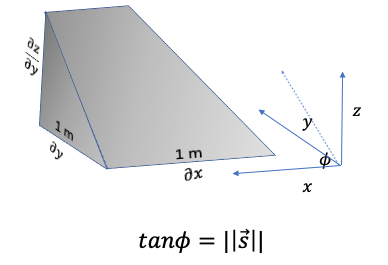

In the graphic above, 

\begin{align}
  \frac{\partial z}{\partial x} =0, \frac{\partial z}{\partial y} = k
\end{align}

Thus, $||\vec{S}|| = \tan \phi =k$


The direction on the (x,y) plane that the slope is increasing is called the topographical aspect, $\omega$. This is measured in radians from a fixed reference point direction. Again, referring to the graphic above, the positive increase in slope only occurs in the *y* direction. Therefore, if the reference direction is on the y axis, then $\omega=0$.

### 2.2 Rothermel formula <a name='Rothermelformula'></a>

The most popular fire surface spread model is the Rothermel fire rate of spread (ROS) formula. Many of the methods and values used in the formula were developed out of laboratory experimentation and field observation. The Rothermel ROS equation has been modified throughout the years upon new discoveries but the formula without wind or slope, today, is given as

\begin{align}
        R_0 = \frac{I_{R}\xi}{\rho_{b}\epsilon Q_{ig}}
\end{align}

Where

$I_R$ = Reaction intensity ($\text{kJ }min^{-1}m^-2$)

$\xi$ = The propagating flux ratio

$\rho_b$ = Ovendry bulk density ($\text{kg } m^{-3}$)

$\epsilon$ = Effective heating number (dimensionless)

$Q_{ig}$ = Heat of pre-ignition ($\text{kJ } kg^{-1}$)




With the addition of wind and slope in the area and time of the simulation, a dimensionless wind factor $\Phi_w$ and a dimensionless slope factor $\Phi_s$. These factors account for their respective input's effect on the increasing reaction intensity on nearby fuel particles. They are incorporated into Rothermel's ROS equation as

$R = \frac{I_{R}\xi(1+\Phi_w+\Phi_s)}{\rho_{b}\epsilon Q_{ig}}$

But the Rothermel formula is one dimensional - it assumes that the directions of the fire propagation, the wind, and the slope are the same. That is, that the three vectors are aligned. We will compare two approaches to extending the Rothermel formula to 2D fire propagation, in FARSITE and in WRF-SFIRE.

##### 2.2.1 ROS Code <a name='ROSCode'></a>

The WRF-SFIRE ROS function was translated from MATLAB into a single python function.

In [ ]:
class WrfTallGrass:
  def __init__(self):
    """Initiates the fuel class"""
    self.fuel_name = '3: Tall grass (2.5 meters)'
    self.windrf = 0.44
    self.fgi    = 0.675
    self.fueldepthm = 0.762
    self.savr   = 1500
    self.fuelmce = 0.25
    self.fueldens = 32
    self.st     = 0.0555
    self.se     = 0.01
    self.weight = 7
    self.fci_d  = 0
    self.fct    = 60
    self.ichap  = 0
    self.fci    = 0
    self.fcbr   = 0
    self.hfgl   = 170000
    self.fuelheat = 7.4962e3
    self.fuelmc_g = 0.08
    self.fuelmc_c = 1
    self.cmbcnst  = 17433000

In [ ]:
def wrf_fire_ros(windspd, tanphi, delta = 0, theta = 0):
  """ ros=wrf_fire_ros(windspd,tanphi,delta, theta)
   ros=fire_ros(fuel,windspd,tanphi,)
   in
         * windspd wind speed (m/s)
         * tanphi slope (grade or rise/run)
         * delta angle(|normal vector - aspect|) radians
         * theta angle(|normal vector - wind direction|) radians
   out
         ros     rate of spread (m/s)
  """
  # given fuel params
  fuel = WrfTallGrass()

  windrf=fuel.windrf;               # WIND REDUCTION FACTOR
  fgi=fuel.fgi;                     # INITIAL TOTAL MASS OF SURFACE FUEL (KG/M**2)
  fueldepthm=fuel.fueldepthm;       # FUEL DEPTH (M)
  savr=fuel.savr;                   # FUEL PARTICLE SURFACE-AREA-TO-VOLUME RATIO, 1/FT
  fuelmce=fuel.fuelmce;             # MOISTURE CONTENT OF EXTINCTION
  fueldens=fuel.fueldens;           # OVENDRY PARTICLE DENSITY, LB/FT^3
  st=fuel.st;                       # FUEL PARTICLE TOTAL MINERAL CONTENT
  se=fuel.se;                       # FUEL PARTICLE EFFECTIVE MINERAL CONTENT
  weight=fuel.weight;               # WEIGHTING PARAMETER THAT DETERMINES THE SLOPE OF THE MASS LOSS CURVE
  fci_d=fuel.fci_d;                 # INITIAL DRY MASS OF CANOPY FUEL
  fct=fuel.fct;                     # BURN OUT TIME FOR CANOPY FUEL, AFTER DRY (S)
  ichap=fuel.ichap;                 # 1 if chaparral, 0 if not
  fci=fuel.fci;                     # INITIAL TOTAL MASS OF CANOPY FUEL
  fcbr=fuel.fcbr;                   # FUEL CANOPY BURN RATE (KG/M**2/S)
  hfgl=fuel.hfgl;                   # SURFACE FIRE HEAT FLUX THRESHOLD TO IGNITE CANOPY (W/m^2)
  cmbcnst=fuel.cmbcnst;             # JOULES PER KG OF DRY FUEL
  fuelheat=fuel.fuelheat;           # FUEL PARTICLE LOW HEAT CONTENT, BTU/LB
  fuelmc_g=fuel.fuelmc_g;           # FUEL PARTICLE (SURFACE) MOISTURE CONTENT, jm: 1 by weight?
  fuelmc_c=fuel.fuelmc_c;           # FUEL PARTICLE (CANOPY) MOISTURE CONTENT, 1

#if exist('fmc_g','var'): # override moisture content by given
    #fuelmc_g = fmc_g;
    ##wont use##


  # computations from CAWFE code: wf2_janice/fire_startup.m4 

  bmst     = fuelmc_g/(1+fuelmc_g);                         # jm: 1 
  fuelheat = cmbcnst * 4.30e-04;                            # convert J/kg to BTU/lb
  fci      = (1+fuelmc_c)*fci_d;
  fuelloadm= (1-bmst) * fgi;                                # fuelload without moisture
                                                            # jm: 1.-bmst = 1/(1+fuelmc_g) so fgi includes moisture? 
  fuelload = fuelloadm * (.3048)**2 * 2.205;                # to lb/ft^2
  fueldepth= fueldepthm/0.3048;                             # to ft
  betafl   = fuelload/(fueldepth * fueldens);               # packing ratio  jm: lb/ft^2/(ft * lb*ft^3) = 1
  betaop   = 3.348 * savr**(-0.8189);                       # optimum packing ratio jm: units??  
  qig      = 250 + 1116*fuelmc_g;                           # heat of preignition, btu/lb
  epsilon  = np.exp(-138/savr );                            # effective heating number
  rhob     = fuelload/fueldepth;                            # ovendry bulk density, lb/ft^3
  c        = 7.47 * np.exp(-0.133 * savr**0.55);            # const in wind coef
  bbb      = 0.02526 * savr**0.54;                          # const in wind coef
  c        = c * windrf**bbb;                               # jm: wind reduction from 20ft per Baughman&Albini(1980)
  e        = 0.715 * np.exp( -3.59e-4 * savr);              # const in wind coef
  phiwc    = c * (betafl/betaop)**(-e); 
  rtemp2   = savr**1.5;
  gammax   = rtemp2/(495. + 0.0594*rtemp2);                 # maximum rxn vel, 1/min
  a        = 1./(4.774 * savr**0.1 - 7.27);                 # coef for optimum rxn vel
  ratio    = betafl/betaop;   
  gamma    = gammax*(ratio**a)*np.exp(a*(1-ratio));         # optimum rxn vel, 1/min
  wn       = fuelload/(1 + st);                             # net fuel loading, lb/ft^2
  rtemp1   = fuelmc_g/fuelmce;
  etam     = 1.-2.59*rtemp1 +5.11*rtemp1**2 -3.52*rtemp1**3;  # moist damp coef
  etas     = 0.174* se**(-0.19);                            # mineral damping coef
  ir       = gamma * wn * fuelheat * etam * etas;           # rxn intensity,btu/ft^2 min
  irm      = ir * 1055/( 0.3048**2 * 60) * 1e-6;            # for mw/m^2 (set but not used)
  xifr     = np.exp( (0.792 + 0.681*savr**0.5)* (betafl+0.1)) /(192 + 0.2595*savr); # propagating flux ratio r_0 is the spread rate for a fire on flat ground with no wind.
  r_0      = ir*xifr/(rhob * epsilon *qig);                 # default spread rate in ft/min

  # print(gamma, wn, fuelheat, etam, etas)

  # computations from CAWFE code: wf2_janice/fire_ros.m4 
  if not ichap:
    #       ... if wind is 0 or into fireline, phiw = 0, &this reduces to backing ros.
 
    spdms = max(np.cos(theta)*windspd,0);
    #spdms = np.cos(theta)*windspd            # Takes away max for negative cos values
    umidm = min(spdms,30);                    # max input wind spd is 30 m/s   !param!
    umid = umidm * 196.850;                    # m/s to ft/min
    umid = float(umid)
    #  eqn.: phiw = c * umid**bbb * (betafl/betaop)**(-e) ! wind coef
    phiw = umid**bbb * phiwc;                   # wind coef
    # phiw = np.real(umid**bbb) * phiwc;                   # wind coef Allows for complex numbers
    #phis = 5.275 * betafl**(-0.3) *max(0,tanphi)**2;   # slope factor
    phis = 5.275 * betafl**(-0.3) *max(0,np.cos(delta)*tanphi)**2;
    ros = r_0*(1 + phiw + phis)  * .00508; # spread rate, m/s
  else:  # chapparal'''
    #        .... spread rate has no dependency on fuel character, only windspeed.
    spdms = max(windspd,0);
    ros = max(.03333,1.2974 * spdms**1.41);       # spread rate, m/s

    ros=min(ros,6);
  return ros 

This is an added plotting function for demonstrative purposes.

In [ ]:
def plot_ros_demo():
  winds = np.linspace(0,15,10)
  slopes = np.round(np.linspace(-0.8,0.8,10),3)
  ros  = np.zeros((len(slopes), len(winds)))

  for j, slope in enumerate(slopes):
    for i, wind in enumerate(winds):
        ros[j][i] = wrf_fire_ros(wind,slope)

  df = pd.DataFrame(ros)
  df = df.T
  columns = [f"{slope} grade slope" for slope in slopes]
  df.columns = columns
  df.index = winds

  df.plot(figsize=(8,8), xlabel='Wind Speed (m/s)', ylabel="ROS m/s");


The FARSITE ROS methods from the RMRS Missoula Fire Science Lab project were translated from C++ into methods of a python Class called FarSurROS. This was done for readability and ease of use when dealing with several methods (introduced later in the FARSITE wind/slope vectoring) that have many variables in common. The FARSITE ROS code requires extra environmental input that was constructed in a way to ensure that the Rothermel function from both WRF-SFIRE and FARSITE produce the same ROS. 

In [ ]:
class EnvironmentData:
  def __init__(self):
    self.m_twindspd = 1
    self.m_ones = 0.0799101
    self.m_tens = 0.0
    self.m_hundreds = 0.0
    self.m_livew = 0.0
    self.m_liveh = 0.0

In [ ]:
class TallGrass():
  def __init__(self):
    self.code    = "FM3"
    self.h1      = 3.010000;
    self.h10     = 0.000000;
    self.h100    = 0.000000;
    self.lh      = 0.000000;
    self.lw      = 0.000000;
    self.dynamic = 0;
    self.sav1    = 1500;
    self.savlh   = 1800;
    self.savlw   = 1500;
    self.depth   = 2.500000;
    self.xmext   = 0.250000;
    self.heatd   = 7496.200000;
    self.heatl   = 8000.000000;
    self.desc    = "Tall Grass";



In [ ]:
class FarSurfROS:
  """This class is the python version of the FARSITE 
  ROS methodology. Input variables are:
    * slope: Tangent Slope (ratio grade) 
    * aspect: direction of the positive slope (radians)
    * winddir: direction of the wind vector (radians)
    * windspd: speed of wind (meters/sec)
    """
  def __init__(self, tangentSlope = 0, aspectf = 0, 
               winddir = 0, windspd = 0):
    
    self.slope = np.arctan(tangentSlope)
    self.aspectf = aspectf
    self.winddir = winddir
    self.windspd = windspd

    #get the Fire Element data
    self.fe = EnvironmentData()

  def set_slope(self, tangentSlope):
    #convert to radians for methods
    self.slope = np.arctan(tangentSlope)

  def set_aspect(self, aspectRad):
    self.aspectf = aspectRad

  def set_winddir(self, winddirRad):
    self.winddir = winddirRad
  
  def set_windspd(self, windspd):
    self.windspd = windspd

  def spreadrate(self):
    # Rothermel spread equation based on BEHAVE source code,
    # support for dynamic fuel models added 10/13/2004
    
    ndead=0
    nlive=0
    seff=[[0.01,0.01],[0.01,0.01],[0.01,0],[0.01,0.0]];	     #mineral content wtfact, beta;
    fined=0.0
    finel=0.0
    wmfd=0.0
    fdmois=0.0
    w=0.0
    wo=0.0
    sigma=0.0
    sum3=0.0
    gammax=0.0
    gamma=0
    wind=0
    rbqig=0
    xi=0
    slopex=0;
    ewind=0
    sum1=0
    sum2=0;


    mois=[[self.fe.m_ones, self.fe.m_liveh], [self.fe.m_tens, self.fe.m_livew], [self.fe.m_hundreds, 0.0], [self.fe.m_ones, 0.0]]
    # fraction of oven-dry weight
    # use Mechanix Class copies of FE data
    gx  = [0.0, 0.0, 0.0, 0.0, 0.0]
    wn  = [[0,0],[0,0],[0,0],[0,0]]
    qig = [[0,0],[0,0],[0,0],[0,0]]
    a   = [[0,0],[0,0],[0,0],[0,0]]
    f   = [[0,0],[0,0],[0,0],[0,0]]
    g   = [[0,0],[0,0],[0,0],[0,0]]
    ai  = [0,0]
    fi  = [0,0]
    hi  = [0,0]
    se  = [0,0]
    xmf = [0,0]
    si  = [0,0]
    wni = [0,0]
    etam = [0,0]
    etas = [0,0]
    rir  = [0,0]

    
    newfuel = TallGrass()


    # count number of fuels
    if newfuel.h1:
      ndead+=1
    if newfuel.h10:
      ndead+=1;
    if newfuel.h100:
      ndead+=1;
    if newfuel.lh:
      nlive+=1;
    if newfuel.lw:
      nlive+=1;
    if nlive==0:
      newfuel.dynamic=0;
    if nlive>0:
      nlive=2;                      # boost to max number
    if ndead>0:
      ndead=4;
      
    nclas=[ndead,nlive]  # # of dead & live fuel classes
    xmext=[newfuel.xmext, 0]

    load=[[newfuel.h1, newfuel.lh],
          [newfuel.h10, newfuel.lw],
          [newfuel.h100, 0.0],
          [0.0, 0.0],]; #tons per acre, later converted to lb/ft2

    depth=newfuel.depth;

    ##-------------------------------------------------------------------------
    ## do the dynamic load transfer
    ##-------------------------------------------------------------------------
    if newfuel.dynamic:
      if(mois[0][1]<0.30): # if live herbaceous is less than 30.0
        load[3][0]=load[0][1];
        load[0][1]=0.0;
      elif(mois[0][1]<1.20):
        load[3][0]=load[0][1]*(1.20-mois[0][1])/0.9;
        load[0][1]-=load[3][0];
      
    ##-------------------------------------------------------------------------
    sav=[[newfuel.sav1, newfuel.savlh], 
         [109.0, newfuel.savlw],
         [30.0, 0.0],
         [newfuel.savlh, 0.0],]# 1/ft

    heat=[[newfuel.heatd, newfuel.heatl],
          [newfuel.heatd, newfuel.heatl],
          [newfuel.heatd, 0.0],
          [newfuel.heatd, 0.0],]

    wind = self.windspd*88.0 # mph to ft/min
    #wind=self.windspd*196.85;                 # m/s to ft/minute
    #slopex=np.tan(self.slope/180.0*np.pi);  	# convert from degrees to tan
    slopex = np.tan(self.slope)

    # fuel weighting factors
    for i in range(2):
     for j in range(nclas[i]):
       a[j][i]=load[j][i]*sav[j][i]/32.0;
       ai[i]=ai[i]+a[j][i];
       wo=wo+0.04591*load[j][i];
     if nclas[i] !=0:
       for j in range(nclas[i]):
         if ai[i]>0.0:
           f[j][i]=a[j][i]/ai[i];
         else:
           f[j][i]=0.0;

       for j in range(nclas[i]):
         if(sav[j][i]>=1200.0):
           gx[0]+=f[j][i];
         elif sav[j][i]>=192.0:
           gx[1]+=f[j][i];
         elif sav[j][i]>=96.0:
           gx[2]+=f[j][i];
         elif sav[j][i]>=48.0:
           gx[3]+=f[j][i];
         elif sav[j][i]>=16.0:
           gx[4]+=f[j][i];

       for j in range(nclas[i]):
         if sav[j][i]>=1200.0:
           g[j][i]=gx[0];
         elif sav[j][i]>=192.0:
           g[j][i]=gx[1];
         elif sav[j][i]>=96.0:
           g[j][i]=gx[2];
         elif sav[j][i]>=48.0:
           g[j][i]=gx[3];
         elif sav[j][i]>=16.0:
           g[j][i]=gx[4];
         else:
           g[j][i] = 0.0

    fi[0]=ai[0]/(ai[0]+ai[1]);
    fi[1]=1.0-fi[0];

    # ORIGINAL COMMENTS:
	  # no need for this, because extinction moistures are assigned */
	  # as on last page of Burgan and Rothermel 1984 */
	  #	rhob=(wo/depth);
		# beta=rhob/32;
		# xmext[0]=.12+4.*beta;
	  
    #moisture of extinction
    if nclas[1]!=0:
      for j in range(nclas[0]):
        wtfact=load[j][0]*np.exp(-138.0/sav[j][0]);
        fined=fined+wtfact;
        wmfd=wmfd+wtfact*mois[j][0];

      fdmois=wmfd/fined;
		
      for j in range(nclas[1]):
        if sav[j][1]<1e-6:
          continue;
        finel=finel+load[j][1]*np.exp(-500.0/sav[j][1]);
          
      w=fined/finel;
      xmext[1]=2.9*w*(1.0-fdmois/xmext[0])-0.226;
      if xmext[1]<xmext[0]:
        xmext[1]=xmext[0];

    # intermediate calculations, summing parameters by fuel component
    for i in range(2):
      if nclas[i]!=0:
        for j in range(nclas[i]):
          if sav[j][i]<1e-6:
            continue;
          wn[j][i]=0.04591*load[j][i]*(1.0-0.0555);
          qig[j][i]=250.0+1116.0*mois[j][i];
          hi[i]=hi[i]+f[j][i]*heat[j][i];
          se[i]=se[i]+f[j][i]*seff[j][i];
          xmf[i]=xmf[i]+f[j][i]*mois[j][i];
          si[i]=si[i]+f[j][i]*sav[j][i];
          sum1=sum1+0.04591*load[j][i];
          sum2=sum2+0.04591*load[j][i]/32.0;
          sum3=sum3+fi[i]*f[j][i]*qig[j][i]*np.exp(-138.0/sav[j][i]);
			
        for j in range(nclas[i]):
          #wni[i]=wni[i]+f[j][i]*wn[j][i];
          wni[i]=wni[i]+g[j][i]*wn[j][i];  # g[j][i] should be subst for f[j][i] in the wni[i] equation */
										   # if the above g-factors are calculated */
        rm=xmf[i]/xmext[i];
        etam[i]=1.0-2.59*rm+5.11*(rm)**2-3.52*pow(rm,3.0);
        if xmf[i] >= xmext[i]:
          etam[i]=0;
        etas[i]=0.174/(pow(se[i],0.19));
        if etas[i]>1.0:
          etas[i]=1.0;
        sigma=sigma+fi[i]*si[i];
        rir[i]=wni[i]*hi[i]*etas[i]*etam[i];
    
    # final calculations */
    rhob   = sum1/depth;
    beta   = sum2/depth;
    betaop = 3.348/pow(sigma,0.8189);
    rat    = beta/betaop;
    aa     = 133.0/pow(sigma,0.7913);
    #gammax=pow(sigma,1.5)/(495.0+0.0594*pow(sigma,1.5));
    gammax = (sigma*np.sqrt(sigma))/(495.0+0.0594*sigma*np.sqrt(sigma));
    gamma  = gammax*pow(rat,aa)*np.exp(aa*(1.0-rat));
    xir    = gamma*(rir[0]+rir[1]);
    rbqig  = rhob*sum3;
    xi     = np.exp((0.792+0.681*np.sqrt(sigma))*(beta+0.1))/(192.0+0.2595*sigma);
    #flux=xi*xir;*/
    rateo  = xir*xi/rbqig;   # this is in English units */
    self.phis   = 5.275*pow(beta,-0.3)*(slopex)**2;
    c      = 7.47*np.exp(-0.133*pow(sigma,0.55));
    b      = 0.02526*pow(sigma,0.54);
    e      = 0.715*np.exp(-0.000359*sigma);
    part1  = c*pow(rat,-e);
    self.phiw   = pow(wind,b)*part1;
    wlim   = 0.9*xir;

    if self.phis>0.0:
      if self.phis>wlim:             # can't have inifinite windspeed
        self.phis=wlim;
      self.slopespd=pow((self.phis/part1),1.0/b)/88.0; 	# converts phis to windspd in mph
    else:
      self.slopespd=0.0;

    #import pdb; pdb.set_trace()

    #rate=(rateo*(1+phiw+phis));    
    #   byram=384*xir*rate/(60*sigma);*/
    # flame=.45*pow(byram,.46);      */
    # hpua=xir*384/sigma;            */

    # maximum windspeed effect on ros*/
    self.phiew=self.phiw+self.phis;
    ewind=pow(((self.phiew*pow(rat,e))/c),1.0/b);

    if ewind>wlim:
      ewind=wlim;
      self.phiew=c*pow(wlim,b)*pow(rat,-e);
   		#rate=rateo*(*phiew+1);	     */
  		#byram=384*xir*rate/(60*sigma);*/
	  	#flame=.45*pow(byram,.46);     */

    savx=sigma;					# SAVX, REACT IN MECHANIX.PUBLIC:
    react=xir*0.189275;  		    	# convert btu/f2/min to kW/m2
    self.rateo=rateo*0.00508;				# convert from f/min to m/sec
    self.ros_generic = rateo*(1+self.phiw+self.phis) 
    return self.rateo

#### ROS Visualization
Simple Rothermel ROS visualization shows the affect of natural conditions of wind and slope and their relationship to a fire's ROS. This visualization assumes that both wind and aspect are in the same direction as the fire propagation. This condition is considered the maximum ROS. 

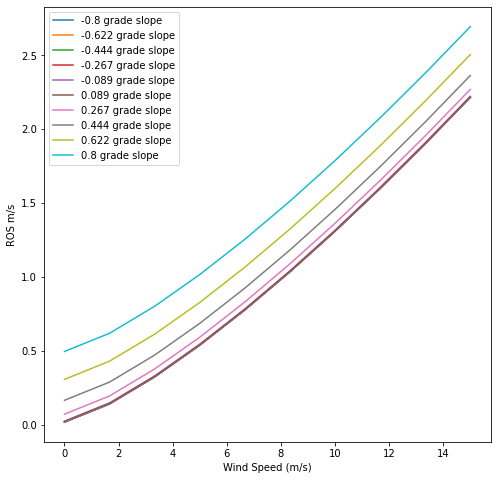

In [ ]:
plot_ros_demo()

### 2.4 Fire propagation by the ellipsoid method in FARSITE <a name='FirepropagationFARSITE'></a>

Richards (1990) and FARSITE (Finney, 2000) assume that fire spreads to an ellipsoid with axes $a$ and $b$, with the fire starting from a point at distance $c$ on the $b$-axis from the center of the ellipse. The $b$ axis is the direction of the maximal Rate of Spread (ROS), which equals to $b+c$, and is computed from the Rothermel formula. Richards (1990) considers only the wind and zero slope, then the direction of the maximal rate of spread is the wind direction. FARSITE computes a "resultant vector" from the slope and wind vectors, which it then substitutes into the Rothermel formula. To find and reproduce how are the computations of the slope and of the resultant vector done is the heart of the project as many of these formulas are missing from the original paper.

#### 2.4.1 Richard's Differential Equations (Huygen's Principle) <a name='DifferentialEquations'></a> 
FARSITE uses Huygen's Principle of wave propagation to explain the movement of the fireline across a surface. The principle applied takes a point on the fireline and uses it to build an ellipse called a wavelet, the wavelet size depends on fuel; whereas wavelet shape and orientation is a result of the local wind and slope condition. Put simply, FARSITE assumes that fire spreads into the shape of an ellipse and everytime the fire is advanced on its elliptical fireline, new smaller ellipses (wavelets) determine where and how far the fireline goes. Each advance on the larger elliptical fireline can be thought of as new fires on the perimeter of the larger elliptical fireline.

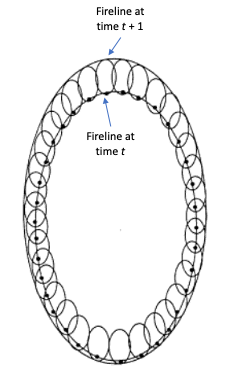


#### 2.4.2 Ellipse Formation <a name='EllipseFormation'></a>

Zoomed in on one of the wavelets, the ellipse diminsions are as follows:




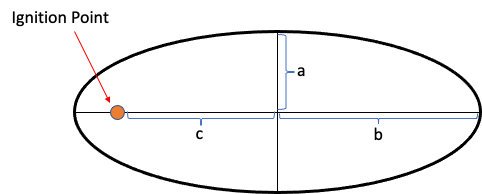


  \begin{align}a  = 0.5(R_{mod} + R_{mod}/HB)/(LB)
  \end{align}
  
  \begin{align}b = (R_{mod} + R_{mod}/HB)/2.0
  \end{align}

  \begin{align}c = b - R_{mod}/HB
  \end{align}

  Where:
  
  $R_{mod}$ = modified Rothermel ROS  ($ms^{-1}$). 
 
 LB = Length to breath ratio for elliptical fire shape 

 HB = Head to back ratio for elliptical fire shape. 

The above parameters that make up a, b, and c will have to unpacked.


##### 2.4.2.1 Wind Slope resultant vector <a name='WindSlope'></a>

The wind-slope resultant vector, $\vec{\tau}$, is integral in both the calculation of $R_{mod}$ as well as in the formation and orientation of the wavelet ellipse. The length and the direction of $\vec{\tau}$ were not found in the original FARSITE paper but were extracted from the FARSITE source code.

  The length of $\vec{τ}$ is determined by
  \begin{align}
        ||\vec{\tau}|| = \sqrt{\Phi_w^2 + \Phi_s^2 + (2 {\Phi_w} + {\Phi_s} \cos(|\gamma-\omega|))}
  \end{align}

Where:
* $\omega$ is the topographic aspect (radians) 
* $\gamma$ is the transformed horizontal wind direction to the local slope coordinates

$\gamma = \tan^{-1}(\frac{\sin(\omega - m)}{\sqrt{\cos(\omega - m)^2+(\cos(\omega - m)\tan\phi)^2}})+\omega-\pi$
* $m$ is the wind direction (radians) determined from $\vec{w}$ 

The direction of $\vec \tau$, which is also the direction of maximimum spread rate, is determined by 

\begin{cases}
    \theta = \omega + \cos^{-1}(\frac{\Phi_w^2-\Phi_s^2-||\vec \tau||}{-2\Phi_s||\vec \tau||}) & \Phi_s \ge \Phi_w \\
    \theta = \cos^{-1}(\frac{\Phi_s^2-\Phi_w^2-||\vec \tau||}{-2\Phi_w||\vec \tau||}) - \gamma & \Phi_s < \Phi_w \\
\end{cases}

###### Length and Direction of $\vec \tau$ Code

In [ ]:
def TransformWindDir(self):  
  '''
  This is under the Mechanix Object
  horizontal wind direction to local slope coordinates
  '''
  #double Theta, slopef
  #double X, Y, Z, S

  if self.fe.m_twindspd==0.0:
    self.LocalWindDir=self.winddir;
    return self.LocalWindDir
    
  #slopef=(self.slope/180.0)*np.pi;
  #already in radians
  slopef = self.slope
  Theta=self.aspectf-self.winddir;
  X=np.cos(Theta)
  Y=np.sin(Theta)
  Z=X*np.tan(slopef);
  S=np.sqrt(X*X+Z*Z);
  #P=sqrt(pow2(S)+pow2(Y));
	#*Ratio=P;

  if X>0.0:
    S=-S
  self.LocalWindDir=np.arctan2(Y, S)+self.aspectf-np.pi;
  #or is it in degrees?

  if self.LocalWindDir<0.0:
    self.LocalWindDir+=2.0*np.pi;

  return self.LocalWindDir

FarSurfROS.TransformWindDir = TransformWindDir

In [ ]:
def vectorspd(self):
  # determines the direction and strength of windXslope vector
  
  angle = abs(self.LocalWindDir - self.aspectf);
  if (angle != np.pi): # dimensionless coefs
    self.vecspeed = np.sqrt(self.phiw**2.0 + self.phis**2.0 + (2.0 * self.phiw * self.phis * np.cos(angle)))
  else:
    self.vecspeed = abs(self.phis - self.phiw);

  return self.vecspeed

FarSurfROS.vectorspd = vectorspd

In [ ]:
def vectordir(self):
  angle = self.LocalWindDir - self.aspectf #m_winddir - ld.aspectf;
  angleabs = abs(angle)
  
  if self.phis >= self.phiw:
    aside = self.phiw
    bside = self.phis
    cside = self.vecspeed
  else:
    aside = self.phis
    bside = self.phiw
    cside = self.vecspeed
  if (bside != 0.0 and cside != 0.0):
    vangle = (aside**2 - bside**2 - cside**2)/(-2.0 * bside * cside)
    if vangle > 1.0:
      vangle = 1.0
    else:
      if vangle < 0.0:
          vangle = np.pi
      else:
        vangle = np.arccos(vangle)
        vangle = abs(vangle)

  else:
    vangle = 0.0
  if angleabs < np.pi:
    if angle > 0.0:
      if self.phiw >= self.phis:
        self.vecdir = self.LocalWindDir - vangle #m_winddir-vangle
      else:
        self.vecdir = self.aspectf + vangle
        
    else:
      if self.phiw >= self.phis:
        self.vecdir = self.LocalWindDir + vangle #m_winddir+vangle
      else:
        self.vecdir = self.aspectf - vangle
  else:
    if angle > 0.0:
      if self.phiw >= self.phis:
        self.vecdir = self.LocalWindDir + vangle #m_winddir+vangle
      else:
        self.vecdir = self.aspectf - vangle
    else:
      if self.phiw >= self.phis:
        self.vecdir = self.LocalWindDir - vangle #m_winddir-vangle;
      else:
        self.vecdir = self.aspectf + vangle
    if self.vecdir < 0.0:
      self.vecdir = 2.0 * np.pi + self.vecdir
      
  return self.vecdir

FarSurfROS.vectordir = vectordir

##### 2.4.2.2 FARSITE Modifed Rothermel ROS Equation <a name='ModifiedRothermel'></a>

The modified rothermel ROS equation, $R_{mod}$, is what drives the lengths of the ellipse diminsions; a, b, and c.

$R_{mod}$ subsitutes the wind and slope factors, $\Phi_w$ and $\Phi_s$ respectively, for the length of the wind-slope resultant vector, $||\vec{\tau}||$, when the slope angle, $\phi$, is greater than 0 radians. When there is no slope or the direction of the fire propagation is down slope, $\Phi_w$ remains as there is no wind-slope vectoring. Trivially, when there is no wind and no slope on the plane, $R_{mod} = R_0$.

\begin{cases} 
      R_{mod} = R_0(1+||\vec{\tau}||) & \phi \gt 0 \\
      R_{mod} = R_0(1+\Phi_{w}) & \phi\leq 0\\
\end{cases}

###### $R_{mod}$ Code

In [ ]:
def VecSurf(self):
  #This is under the MechCalls Object
  self.spreadrate()
	# calculates wind/slope vector for surface fire
  if (self.slope > 0):
    self.TransformWindDir();  # transform horiz to slope coords
    self.vectorspd();
    self.vectordir(); 	 # spread vector direction
    if (self.vecspeed > self.phiew):
      self.vecspeed = self.phiew;   		 # vecspeed is still dimensionless
    self.vecros = (self.rateo * (1.0 + self.vecspeed));   # wind/slope vectored spread rate
  else:
    self.vecdir = self.winddir;
    #ivecspeed = m_windspd;
    #if (phiw > phiew):
    #  phiw = phiew; #phiw is the wind component of the vector
    self.vecspeed = self.phiw; #vecspeed angles taken in radians
    self.vecros = (self.rateo * (1.0 + self.phiw));	# winddriven spread rate in wind direction
    return self.vecros

FarSurfROS.VecSurf = VecSurf

##### 2.4.2.3 Elliptical Fire Size Proportions <a name='EllipticalFireSize'></a>

Anderson (1983) found that elliptical proportion sizes are dependent on functions of wind.   
\begin{align}
LB = 0.936e^{0.2566||w||} + 0.461e^{-0.1548||w||}
\end{align}
 \begin{align}
         HB = (LB + (LB^2 - 1)^{0.5})/(LB-(LB^2 - 1)^{0.5}) 
    \end{align}
FARSITE employs a slightly modified version of this wind driven model by incorporating the slope through $||\vec{\tau}||$. FARSITE also subtracts the constant 0.397 to ensure that when there is no wind and no slope present, the elliptical fire shows equal spread in all directions (e.g. a circle).

\begin{align}
         LB = 0.936e^{0.2566||\vec{\tau}||} + 0.461e^{-0.1548||\vec{\tau}||} - 0.397 
    \end{align}

  Where: 
 
 
 LB = Length to breath ratio for elliptical fire shape 

 HB = Head to back ratio for elliptical fire shape.

###### Elliptical Dimensions Code

In [ ]:
def ellipse(self):
  #calculates spread rate parameters for ellipse
	#ivecspeed=ivecspeed*1.6096;  /* convert to km/hr for ALEXANDER'S EQUATION*/
	#then multiply ivecspeed for 20 ft ws by 1.15 to get 10-m open ws for Alexander's equations
	#need ivecspeed boosted to effective 10-m windspeed
	#this would require passing cover and fuel type to this function
	#lb_ratio=.5+.5*exp(.05039*ivecspeed); // ALEXANDER'S EQUATION [36]
	#ANDERSON 1983 FOR MIDFLAME WINDSPEED
  self.VecSurf()
  constBack = False

  lb_ratio = .936 * np.exp(.1147 * self.vecspeed) + .461 * np.exp(-.0692 * self.vecspeed) - .397
   
  if (lb_ratio > 8.0): 			 # maximum eccentricity
    lb_ratio = 8.0;
  #hb_ratio = headback();		 #	subt 0.397 to make circle at 0 windspd (my own addition)
  part = np.sqrt(lb_ratio**2.0 - 1)
  hb_ratio = (lb_ratio + part) / (lb_ratio - part);
  head = self.vecros
  if (constBack):
    back = self.rateo;			# backing ros should be ros with 0 slope & wind
  else:
    back = head / hb_ratio;		# backspread from hb_ratio from Alexander 1985
  self.a_flank = ((head + back) / lb_ratio) / 2.0;
  self.b_head = (head + back) / 2.0; 
  self.c_back = self.b_head - back;			# modifies rates of spread for elliptical dimensions

FarSurfROS.ellipse = ellipse

### 2.5 Fire propagation in WRF-SFIRE <a name='FirepropagationWRF-SFIRE'></a>

WRF-SFIRE works with ROS in the direction of the normal to the fireline, and applies Rothermel's formula along the normal. That is, it substitutes in the Rothermel formula the wind speed projected on the normal (i.e., multiplied by the cosine of the wind vector and the normal vector), and the slope (i.e, slope of the gradient of the terrain height) also projected on the normal (i.e., multiplied by the cosine of the slope direction in the horizontal plane and the normal vector). WRF-SFIRE also includes modifications to impose a minimum lateral and backing fire spread.


*here*

## 3 Methods <a name='Methods'></a>

To compare the fire propagation in WRF-SFIRE and FARSITE, we will find the ROS in the direction normal to the fireline that is equivalent to the propagation of the same fireline in the FARSITE ellipsoid method.

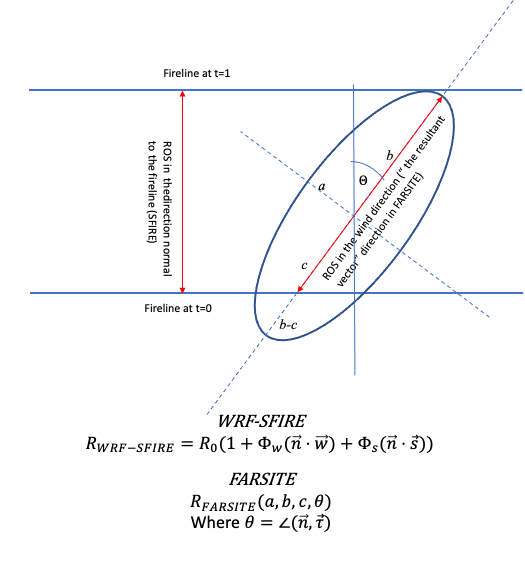

### 3.1 Computing the rate of spread in the direction normal to the fireline from the fire propagation ellipsoid <a name='ComputingROS'></a>

Write the equation of an ellipse with horizontal axis $a$ and vertical axis
$b$ in parametric form
$$
\left[
\begin{array}
[c]{c}
x\\
y
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
a\cos s\\
b\sin s
\end{array}
\right] .
$$
Rotate by an angle $\theta$ clockwise:
$$
\left[
\begin{array}
[c]{c}
x\\
y
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\cos\theta & \sin\theta\\
-\sin\theta & \cos\theta
\end{array}
\right]  \left[
\begin{array}
[c]{c}
a\cos s\\
b\sin s
\end{array}
\right]  .
$$
Multiplying out we get
$$
\left[
\begin{array}
[c]{c}
x\\
y
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
a\cos\theta\cos s+b\sin\theta\sin s\\
-a\sin\theta\cos s+b\cos\theta\sin s
\end{array}
\right]  .
$$
Move the center vertically so that the point at distance $c$ from the bottom
vertex on the $b$ axis is at $y=0$,
$$
\left[
\begin{array}
[c]{c}
x\\
y
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
a\cos\theta\cos s+b\sin\theta\sin s\\
-a\sin\theta\cos s+b\cos\theta\sin s+(b-c)\cos\theta
\end{array}
\right]
$$
This is the equation of the ellipse from the figure. The rate of spread in the
direction of the normal equivalent to the ellipse is the distance of the
horizontal lines at $y=0$ and tangent to the top of the rotated shifted
ellipse
$$
R=\max_{s}-a\sin\theta\cos s+b\cos\theta\sin s+(b-c)\cos\theta
$$
The find the highest point, set
$$
y^{\prime}\left(  s\right)  =\frac{\partial}{\partial s}\left(  -a\sin
\theta\cos s+b\cos\theta\sin s+(b-c)\cos\theta\right)  =0
$$
which gives
$$
a\sin\theta\sin s+b\cos\theta\cos s=0
$$
We can either divide by $\sin\theta\neq0$,
$$
\frac{\sin s}{\cos s}+\frac{b}{a}\frac{\cos\theta}{\sin\theta}=0,
$$
and compute $s$ from
$$
s=-\arctan\left(  \frac{b\cos\theta}{a\sin\theta}\right)
$$
Using the arctan2 function in numpy
$$
s=-\text{arctan2}\left(  b\cos\theta,a\sin\theta\right)
$$
gives the correct result even for $\sin\theta=0.$ In any case, we get two solutions, $s$
and $s+\pi$,  substitute in the equation of the ellipse
$$
y=-a\sin\theta\cos s+b\cos\theta\sin s+\left(  b-c\right)  \cos\theta
$$
and take the larger value:
$$
R=\max\left\{  u,-u\right\}  +c\cos\theta,\quad u=-a\sin\theta\cos
s+b\cos\theta\sin s.
$$


#### Compute ROS in the direction normal to the fireline for FARSITE

The code to compute $R$ from $a,b,c,\theta$ turns out to be just three lines.

In [ ]:
import numpy as np
def ros_n(self,propagationDir):
  # compute fire rate of spread in the direction normal to the fireline for fire
  # propagating according the the ellipsoid method with coefficients a, b, c 
  # and the main axis of the ellipsoid at angle theta from the normal
  self.theta = propagationDir-self.vecdir
  if self.theta < 0:
    self.theta+=2.0*np.pi

  s = -np.arctan2(self.b_head*np.cos(self.theta),self.a_flank*np.sin(self.theta))
  u = -self.a_flank*np.sin(self.theta)*np.cos(s) + self.b_head*np.cos(self.theta)*np.sin(s)
  self.ros_normal = np.maximum(u,-u) + self.c_back*np.cos(self.theta)

FarSurfROS.ros_n = ros_n

In [ ]:
import numpy as np
def ros_n_static(a,b,c,theta):
  # compute fire rate of spread in the direction normal to the fireline for fire
  # propagating according the the ellipsoid method with coefficients a, b, c 
  # and the main axis of the ellipsoid at angle theta from the normal
  
  s = -np.arctan2(b*np.cos(theta),a*np.sin(theta))
  u = -a*np.sin(theta)*np.cos(s) + b*np.cos(theta)*np.sin(s)
  R = np.maximum(u,-u) + c*np.cos(theta)
  #print('a',a,'b',b,'c',c,'theta',theta)
  # print('s',s,'u',u,'R',R)
  return R

### Visualization

If it's not programmed and if it doesn't work it's just a fantasy. Let's draw some pictures to verify.

#### Visualization code

In [ ]:
def plot_ros(self):
  
  def xe(s):   # x coordinate of point on the ellipse
    return self.a_flank*np.cos(self.theta)*np.cos(s) + self.b_head*np.sin(self.theta)*np.sin(s)
  def ye(s):   # c coordinate of point on the ellipse
    return -self.a_flank*np.sin(self.theta)*np.cos(s) + self.b_head*np.cos(self.theta)*np.sin(s) + self.c_back*np.cos(self.theta)
  def cline(t,m): # plot line through the center at angle t
    plt.plot([xe(t), xe(t+np.pi)], [ye(t), ye(t+np.pi)],marker='o',linestyle='-.',c=m)
  %matplotlib inline
  plt.figure(figsize=(8,8))
  s=np.linspace(0,2*np.pi,1000)  # parameter
  x = xe(s)
  y = ye(s)
  plt.plot(x,y,      linestyle='--',c='r',label='fire propagation ellipsoid at t=1s')
  cline(0.0,'b')
  cline(np.pi/2,'r')
  xx=np.linspace(-self.b_head,self.b_head,100)
  oo=np.ones(100)
  plt.plot(xx,oo*self.ros_normal,  linestyle='-',c='k',label='fireline at t=1s')
  plt.plot(xx,oo*0.0,linestyle='--',c='k',label='fireline at t=0s')

  plt.ylabel('fire traveled in normal direction (m)')
  plt.title('Normal ROS %s m/s for ellipsoid with a=%s m/s b=%s m/s c=%s m/s at %s rad angle' 
            % (np.round(self.ros_normal,4),np.round(self.a_flank,4),np.round(self.b_head,4),np.round(self.c_back,4),np.round(self.theta,4)))
  plt.axis('equal')
  plt.legend()

  #plt.show()

FarSurfROS.plot_ros = plot_ros


In [ ]:
def plot_ros_static(a,b,c,theta):
  r=ros_n_static(a,b,c,theta)
  def xe(s):   # x coordinate of point on the ellipse
    return a*np.cos(theta)*np.cos(s) + b*np.sin(theta)*np.sin(s)
  def ye(s):   # c coordinate of point on the ellipse
    return -a*np.sin(theta)*np.cos(s) + b*np.cos(theta)*np.sin(s) + c*np.cos(theta)
  def cline(t,m): # plot line through the center at angle t
    plt.plot([xe(t), xe(t+np.pi)], [ye(t), ye(t+np.pi)],marker='o',linestyle='-.',c=m)
  %matplotlib inline
  plt.figure(figsize=(8,8))
  s=np.linspace(0,2*np.pi,1000)  # parameter
  x = xe(s)
  y = ye(s)
  plt.plot(x,y,      linestyle='--',c='r',label='fire propagation ellipsoid at t=1s')
  cline(0.0,'b')
  cline(np.pi/2,'r')
  xx=np.linspace(-b,b,100)
  oo=np.ones(100)
  plt.plot(xx,oo*r,  linestyle='-',c='k',label='fireline at t=1s')
  plt.plot(xx,oo*0.0,linestyle='--',c='k',label='fireline at t=0s')
  plt.ylabel('fire traveled in normal direction (m)')
  plt.title('Normal ROS %s m/s for ellipsoid with a=%s m/s b=%s m/s c=%s m/s at %s rad angle' 
            % (np.round(r,4),np.round(a,4),np.round(b,4),np.round(c,4),np.round(theta,decimals=4)))
  plt.axis('equal')
  plt.legend()



In [ ]:
def wrf_plot_ros(wrfRos,propagationDir):
  #wrf plotting
  x = np.linspace(0,1,1000)
  y = np.linspace(0,1,1000)
 
  # Creating plot
  fig,ax = plt.subplots(figsize = (8,8))
  plt.plot(x*0, y*wrfRos,'b', label = 'WRF-SFIRE')
  plt.plot(0,wrfRos, 'or')

  #firelines
  xx=np.linspace(-wrfRos,wrfRos,100)
  oo=np.ones(100)
  plt.plot(xx,oo*wrfRos,  linestyle='-',c='k',label='fireline at t=1s')
  plt.plot(xx,oo*0.0,linestyle='--',c='k',label='fireline at t=0s')

  #center axis
  yabs_max = abs(max(ax.get_ylim(), key=abs))
  ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
  xabs_max = abs(max(ax.get_xlim(), key=abs))
  ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
  
  # show plot
  plt.title('Normal ROS %s m/s for WRF-SFIRE' % np.round(wrfRos,decimals=4))
  ax.axis('equal')
  ax.legend()

#### Pictures

##### Direction of the propagation of the fireline (the normal to the fireline) is the same as the maximum spread direction:

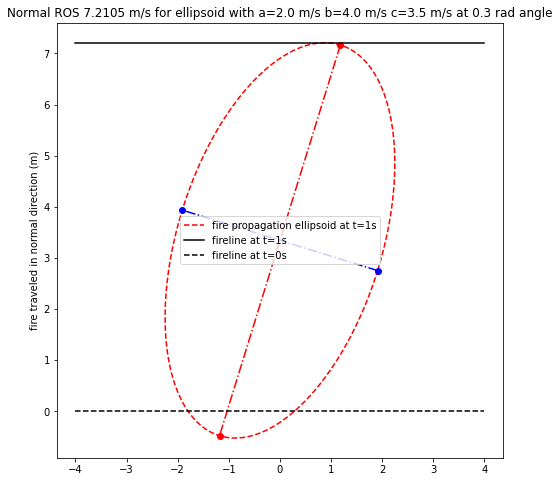

In [ ]:
plot_ros_static(2.0,4.0,3.5,0.3)

Here, the ROS in the ellipsoid method and the ROS in the normal direction as the same.

##### The maximum ROS in the ellipsoid method at an angle to the normal direction:

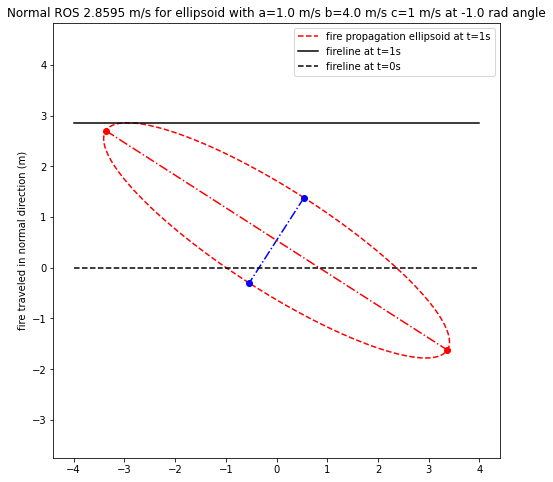

In [ ]:
plot_ros_static(1.0,4.0,1,-1.0)

Here, the ROS in the normal direction is *smaller* than the maximum ROS from the ellipsoid method.

##### The case when the the axes $a=b$ in the ellipsoid method and at angle to the fireline:

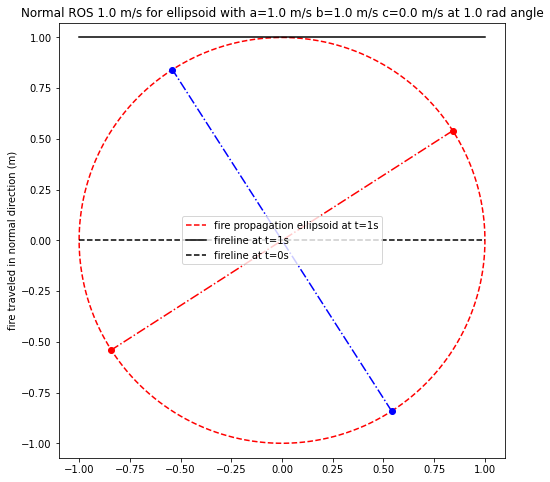

In [ ]:
plot_ros_static(1.0,1.0,0.0,1.0)

Here, the ROS as the speed of the movement of the fireline in the normal direction is *larger* than the maximum ROS in any direction in the ellipsoid method. This is because the movement of the fireline is computed from the *envelope* of all ellipsoids, not just from one ellipsoid.



##### The case when the maximum ROS in the ellipsoid method is backwards to the propagation of the fireline

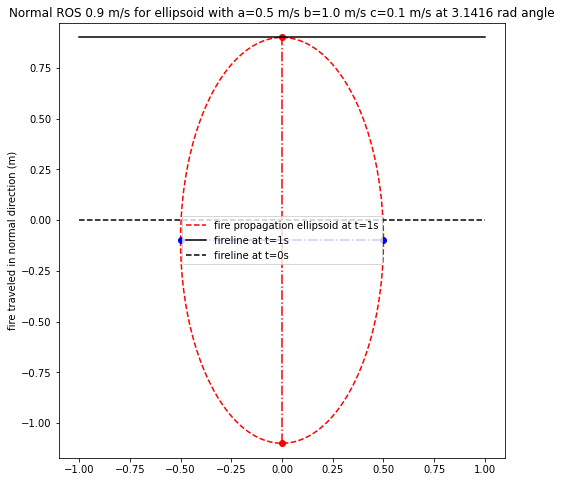

In [ ]:
plot_ros_static(0.5,1.0,0.1,np.pi)

So $c$ is the *backing ROS* - the speed how fire propagates backwards.

##### An example when the maximum ROS in the ellipsoid method points backwards at an angle:

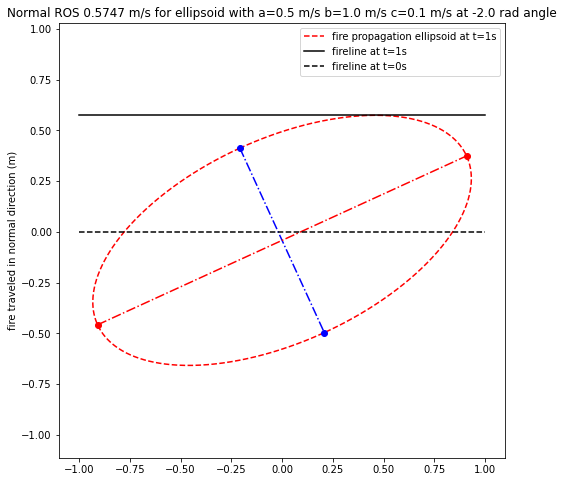

In [ ]:
plot_ros_static(0.5,1.0,0.1,-2.0)

##### The case when the maximum ROS in the ellipsoid method is aligned with the fireline:

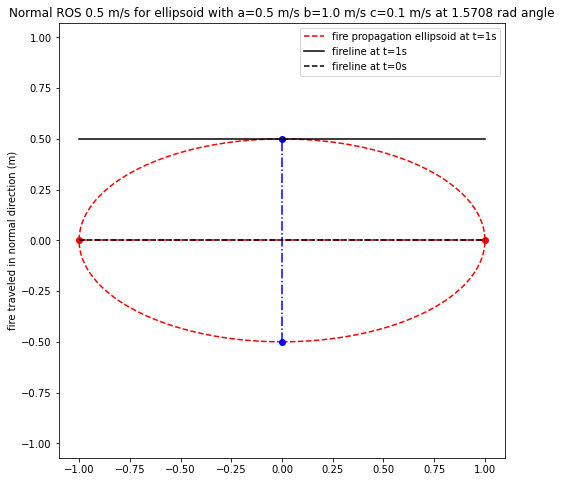

In [ ]:
plot_ros_static(0.5,1.0,0.1,np.pi/2)

So $a$ becomes the *lateral ROS* - the speed how a fire propagates sidewise.

###### Input Vectors Code

In [ ]:
def rosVectorInput(wind, slope, propagationDir = 0):
  """inputs:
  * wind: two element vectored wind over latitude and longitude (m/s)
  * slope: two element vector (meters)
  * propagationDir: direction of propagation (radians)
  """

  #wind vector magnitude and direction
  windspd = abs(np.sqrt(wind[0]**2 + wind[1]**2))
  winddir = np.arctan2(wind[0],wind[1])

  if winddir < 0:
    winddir += 2*np.pi

  #slope ratio and direction
  tanphi = abs(np.sqrt(slope[0]**2+slope[1]**2))
  aspectDir = np.arctan2(slope[0],slope[1])

  if aspectDir<0:
    aspectDir +=2*np.pi

  #Input vector polar plots
  fig, (ax1,ax2,ax3) = plt.subplots(1,3,subplot_kw=dict(projection='polar'))
  ax1.set_title('Wind Vector')
  ax1.plot(np.ones((1000,1))*winddir,np.linspace(0,windspd,1000))
  ax1.set_theta_zero_location("N")
  ax1.set_theta_direction(-1)
  ax2.set_title('Slope Vector')
  ax2.plot(np.ones((1000,1))*aspectDir,np.linspace(0,tanphi,1000))
  ax2.set_theta_zero_location("N")
  ax2.set_theta_direction(-1)
  ax3.set_title('Propagation Direction')
  ax3.plot(np.ones((1000,1))*propagationDir,np.linspace(0,1,1000))
  ax3.set_theta_zero_location("N")
  ax3.set_theta_direction(-1)
  plt.rcParams['axes.titlepad'] = 20
  fig.tight_layout()
  plt.show()

  #for WRF
  theta = abs(propagationDir - winddir)
  delta = abs(propagationDir - aspectDir)

  #Wrf
  wrfRos = wrf_fire_ros(windspd, tanphi, delta, theta)

  #Farsite
  farRos = FarSurfROS(tanphi,aspectDir,winddir,windspd)
  farRos.ellipse()
  farRos.ros_n(propagationDir)
  farRos.plot_ros()

  #plot wrf
  wrf_plot_ros(wrfRos,propagationDir)
  

#### Full FARSITE Ellipse Pictures

##### ROS with no wind or slope

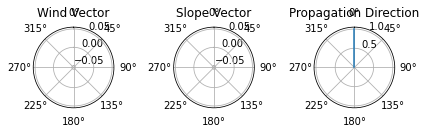

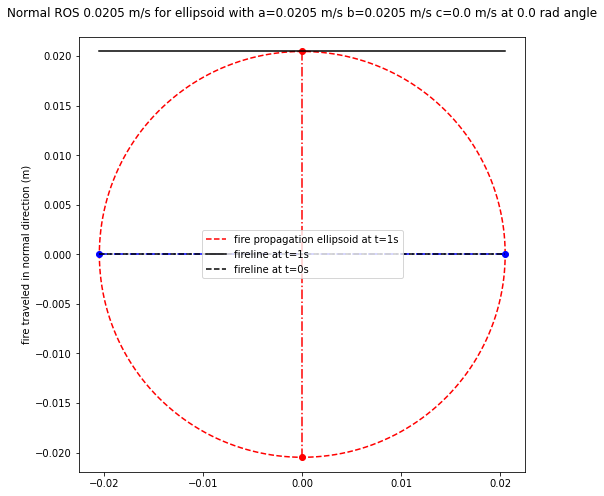

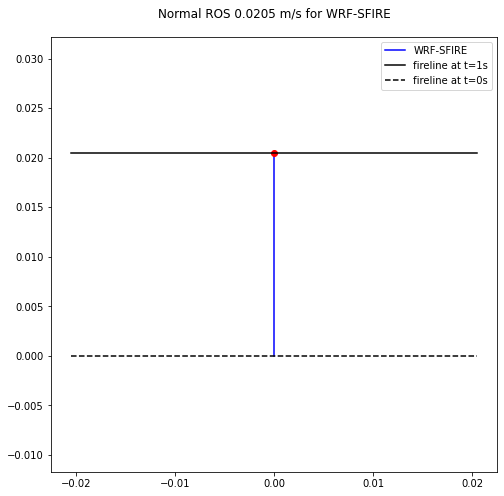

In [ ]:
wind = [0,0]
slope = [0,0]
rosVectorInput(wind, slope)

##### Wind Direction and Aspect aligned with Propagation Direction

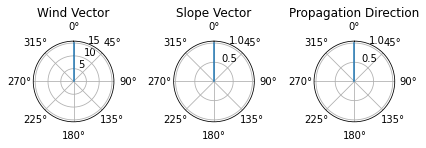

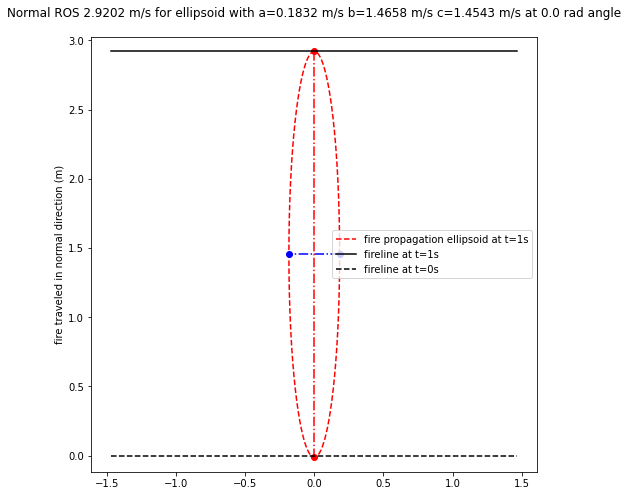

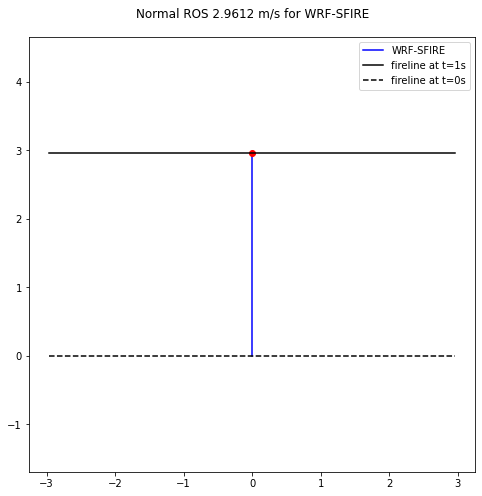

In [ ]:
wind = [0,15]
slope = [0,1]
rosVectorInput(wind, slope)

##### Wind Direction and Aspect Opposite of Propagation Direction

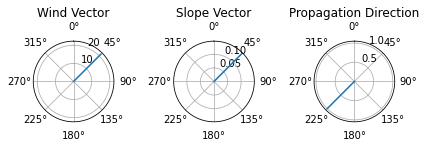

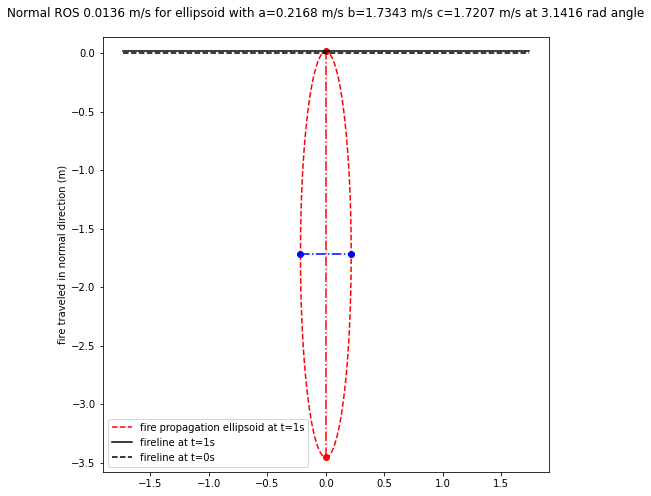

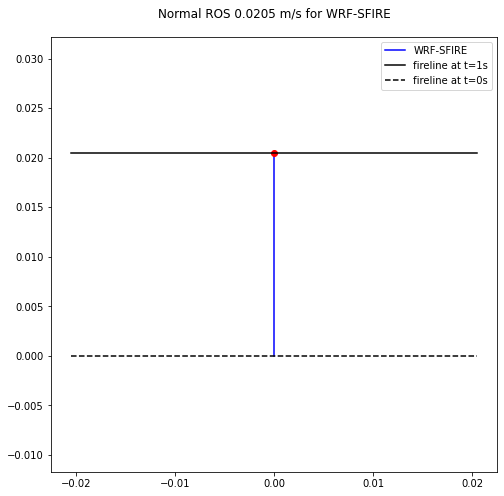

In [ ]:
wind = [15,15]
slope = [0.1,0.1]
rosVectorInput(wind, slope,np.deg2rad(225))

##### Wind and Propagation Direction are aligned While Slope is in the Opposite Direction

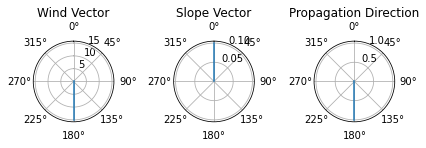

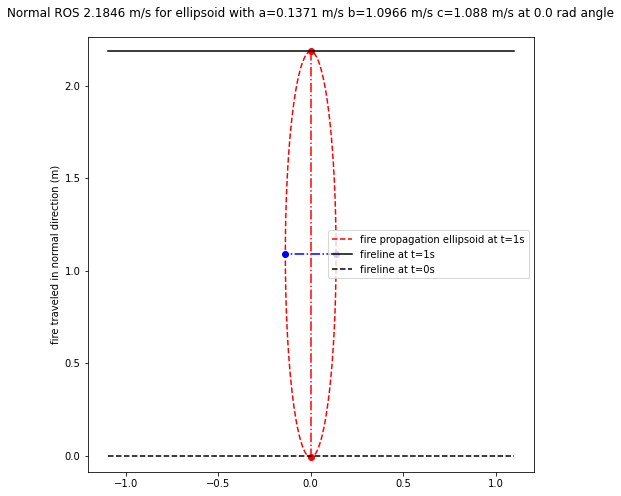

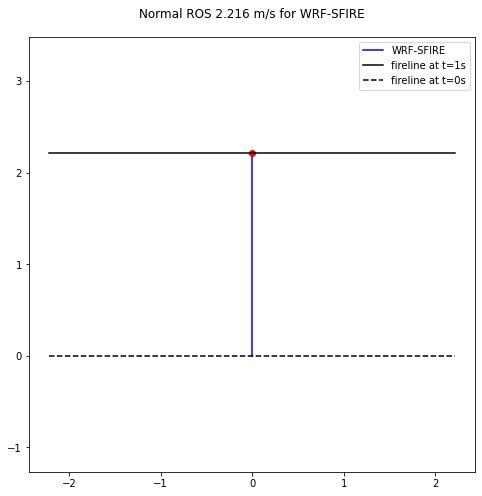

In [ ]:
wind = [0,-15]
slope = [0,0.1]
rosVectorInput(wind, slope,np.deg2rad(180))

##### Slope and Propagation are aligned While Wind is in Opposite Direction

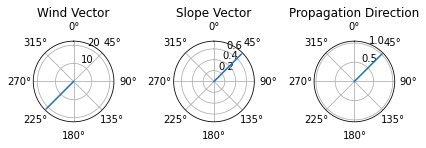

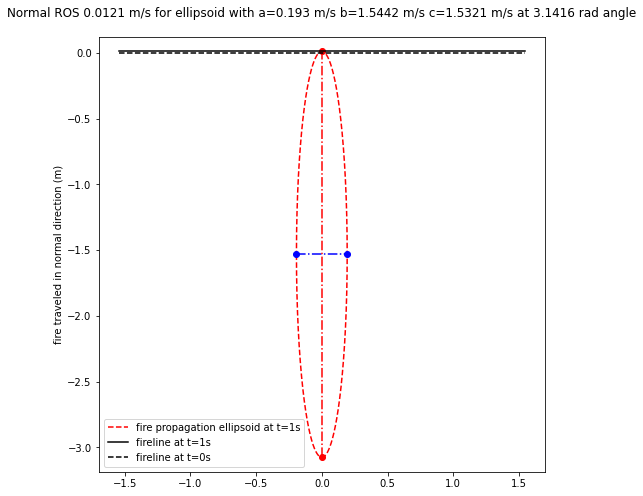

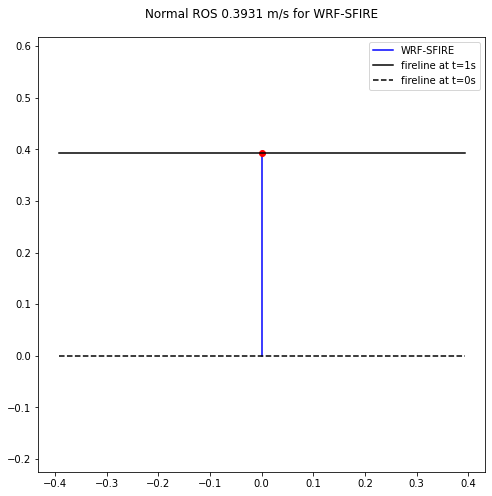

In [ ]:
wind = [-15,-15]
slope = [0.5,0.5]
rosVectorInput(wind, slope,np.deg2rad(45))

##### Wind and Slope in Opposite Directions while Propagation Direction is Normal to both

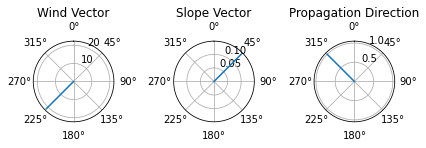

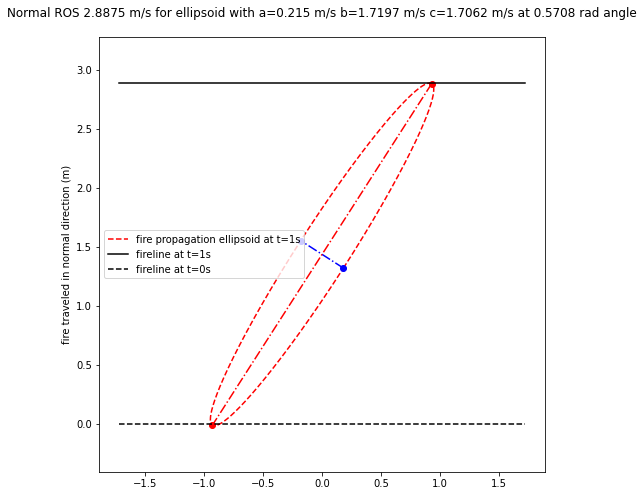

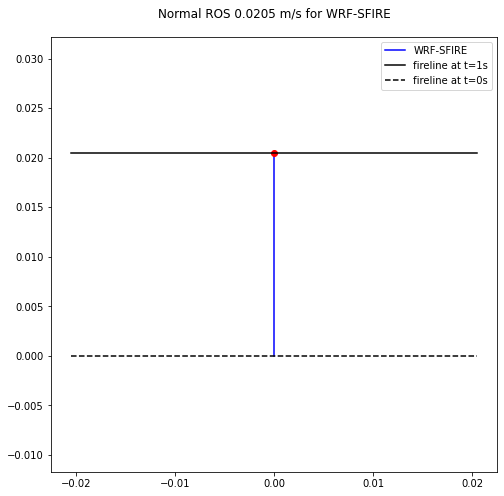

In [ ]:
wind = [-15,-15]
slope = [0.1,0.1]
rosVectorInput(wind, slope,np.deg2rad(315))

## 4 Results <a name='Results'></a>

We found that when $\vec{w}$, $\vec{s}$, and $\vec{n}$ are aligned, the ROS for the FARSITE and WRF-SFIRE methods are comparable. When $\vec{w}$ and $\vec{s}$ are aligned but $\vec{n}$ is in the opposite direction, the backing ROS for WRF-SFIRE, which happens to be $R_0$, is slightly higher than that of FARSITE. The largest difference appears when $\vec{w}$ and $\vec{s}$ are in opposite directions and $\vec{n}$ is normal to both. In this case the countering $\vec{w}$ and $\vec{s}$ input vectors cancel one another to allow the fireline to advance at the speed of $R_0$. The elliptical method of FARSITE advances the fireline at a significantly higher rate.

## 5. Conclusion  <a name='conclusion'></a>

In order to compare the two spread rate models accurately, they both had to be converted to python. Using a jupyter notebook we were able to compile and run both models side by side. The inaccuracies in the outputs are simply a byproduct of rounding conversion factors. 
In cases where the vectors are aligned and wind and slope are zero it is possible to say that the spread rates are equal. The fire line is moving at the same speed in the same direction. Once differences are introduces to allow the wind a slope vector inputs to oppose one another, FARSITE and WRF-SFIRE advance the fireline at different speeds.
The spread rate in both models is dependent on the fuel type. For both, the same fuel was selected when running comparisons. 


##Contributions of authors  <a name='Contributions'></a>

Chris was the team leader, Efosa helped with data visualization, Austin helped us with coding, and Racheal helped with modeling. We all contributed in the modeling part of the project. Also Chris, Efosa and Austin did the coding part of the project. All authors are assumed to have reviewed and approve the publication.

##Acknowledgements  <a name='acknowledgements'></a>

This Math Clinic was sponsored by the project " Coupled Interactive Forecasting of Weather, Fire Behavior, and Smoke Impact for Improved Wildland Fire Decision Making" in the NASA Disaster program, Principal Investigator Kyle Hilburn, Cooperative Institute for Research in the Atmosphere, Colorado State University.

# References  <a name='references'></a>

[1] J. Mandel, J. D. Beezley, and A. K. Kochanski, “Coupled atmosphere-wildland fire modeling with WRF  3.3 and SFIRE 2011,” Geoscientific Model Development, vol. 4, no. 3, pp. 591–610, Jul. 2011, Accessed December 6, 2021 [doi: 10.5194/gmd-4-591-2011](https://gmd.copernicus.org/articles/4/591/2011/gmd-4-591-2011.pdf) 

[2] M. A. Finney, "FARSITE : fire area simulator : model development and evaluation," Ogden, Ut: U.S. Dept. Of Agriculture, Forest Service, Rocky Mountain Research Station, 2004. Accessed December 6, 2021 [doi:10.2737/RMRS-RP-4](https://doi.org/10.2737/RMRS-RP-4) 

[3] R. C. Rothermel, "A mathematical model for predicting fire spread in wildland fuels," Ogden, Utah: Intermountain Forest & Range Experiment Station, Forest Service, U.S. Dept. Of Agriculture, 1972. Accessed December 6, 2021 https://www.fs.usda.gov/treesearch/pubs/32533 

[4] G. D. Richards, “An elliptical growth model of forest fire fronts and its numerical solution,” International Journal for Numerical Methods in Engineering, vol. 30, no. 6, pp. 1163–1179, Oct. 1990, Accessed December 6, 2021 [doi: 10.1002/nme.1620300606](https://www.fs.fed.us/rm/pubs_int/int_rp115.pdf). 

[5] Hal E. Anderson, "Predicting Wind-Driven Wild Land Fire Size and Shape," Ogden, Utah: Intermountain Forest & Range Experiment Station, Forest Service, U.S. Dept. Of Agriculture, 1983. Accessed December 10,2021 https://www.frames.gov/documents/behaveplus/publications/Anderson_1983_INT-RP-305_ocr.pdf